In [191]:
import pandas_datareader as pdr
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [28]:
ba = pd.read_csv("/Users/tongwu/Downloads/BA.csv")

In [29]:
ba.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-07-09,0.664609,0.679012,0.658436,0.664609,0.156832,473600
1,1962-07-10,0.681070,0.697531,0.681070,0.681070,0.160716,1074800
2,1962-07-11,0.681070,0.687243,0.676955,0.685185,0.161688,491600
3,1962-07-12,0.685185,0.693416,0.679012,0.679012,0.160231,801800
4,1962-07-13,0.679012,0.687243,0.676955,0.681070,0.160716,400800


In [40]:
ba.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
14342,2019-07-01,364.880005,365.230011,353.320007,356.459991,356.459991,6409600
14343,2019-07-02,355.630005,356.779999,352.690002,354.160004,354.160004,3774700
14344,2019-07-03,354.500000,354.850006,352.260010,354.470001,354.470001,2164900
14345,2019-07-05,354.000000,357.250000,351.429993,355.859985,355.859985,3208200
14346,2019-07-08,350.410004,352.959991,349.399994,351.119995,351.119995,3104200


In [33]:
ba.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [37]:
ba['Date'] = pd.to_datetime(ba['Date'])
ba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14347 entries, 0 to 14346
Data columns (total 7 columns):
Date         14347 non-null datetime64[ns]
Open         14347 non-null float64
High         14347 non-null float64
Low          14347 non-null float64
Close        14347 non-null float64
Adj Close    14347 non-null float64
Volume       14347 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 784.7 KB


In [38]:
ba.describe()

,Open,High,Low,Close,Adj Close,Volume
count,14347.000000,14347.000000,14347.000000,14347.000000,14347.000000,1.434700e+04
mean,43.384724,43.841957,42.918367,43.396385,35.303276,2.888124e+06
std,67.664602,68.350829,66.957391,67.690129,65.517688,2.415232e+06
min,0.382716,0.390947,0.382716,0.382716,0.118716,7.280000e+04
25%,2.374485,2.407408,2.350823,2.370370,0.709669,1.251200e+06
50%,19.583334,19.812500,19.416666,19.583334,11.290849,2.366400e+06
75%,55.250000,56.000000,54.545000,55.168751,38.180269,3.819600e+06
max,446.010010,446.010010,440.190002,440.619995,438.103058,4.439180e+07


In [82]:
airbus = pd.read_csv("/Users/tongwu/Downloads/AIR.PA.csv")

In [83]:
airbus.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-09-03,19.040001,19.240000,18.920000,18.990000,13.228451,322507.0
1,2001-09-04,19.379999,19.940001,19.059999,19.940001,13.890222,2124573.0
2,2001-09-05,19.700001,19.930000,19.670000,19.700001,13.723036,1135245.0
3,2001-09-06,19.549999,19.700001,19.059999,19.059999,13.277212,1730852.0
4,2001-09-07,19.150000,19.350000,18.020000,18.110001,12.615442,1660196.0


In [84]:
airbus.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4578,2019-07-02,122.900002,124.279999,122.599998,123.959999,123.959999,1028534.0
4579,2019-07-03,124.279999,126.040001,123.820000,125.639999,125.639999,675445.0
4580,2019-07-04,125.599998,125.959999,124.440002,125.379997,125.379997,454665.0
4581,2019-07-05,124.540001,125.199997,123.699997,124.580002,124.580002,724073.0
4582,2019-07-08,124.199997,124.419998,123.000000,123.919998,123.919998,788487.0


In [85]:
airbus.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [86]:
airbus['Date'] = pd.to_datetime(airbus['Date'])
airbus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4583 entries, 0 to 4582
Data columns (total 7 columns):
Date         4583 non-null datetime64[ns]
Open         4556 non-null float64
High         4556 non-null float64
Low          4556 non-null float64
Close        4556 non-null float64
Adj Close    4556 non-null float64
Volume       4556 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 250.7 KB


In [87]:
airbus.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4556.000000,4556.000000,4556.000000,4556.000000,4556.000000,4.556000e+03
mean,36.771475,37.222563,36.317326,36.785760,33.141921,2.531904e+06
std,27.177968,27.410631,26.951553,27.197947,27.642240,1.959252e+06
min,6.490000,7.050000,6.330000,6.500000,4.660456,0.000000e+00
25%,17.059999,17.450001,16.807499,17.132499,13.288148,1.526677e+06
50%,23.980000,24.180000,23.670000,23.969999,19.496648,2.093258e+06
75%,52.362501,52.970001,51.795001,52.372499,48.058124,2.977160e+06
max,125.599998,126.500000,124.580002,125.639999,125.639999,6.833590e+07


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

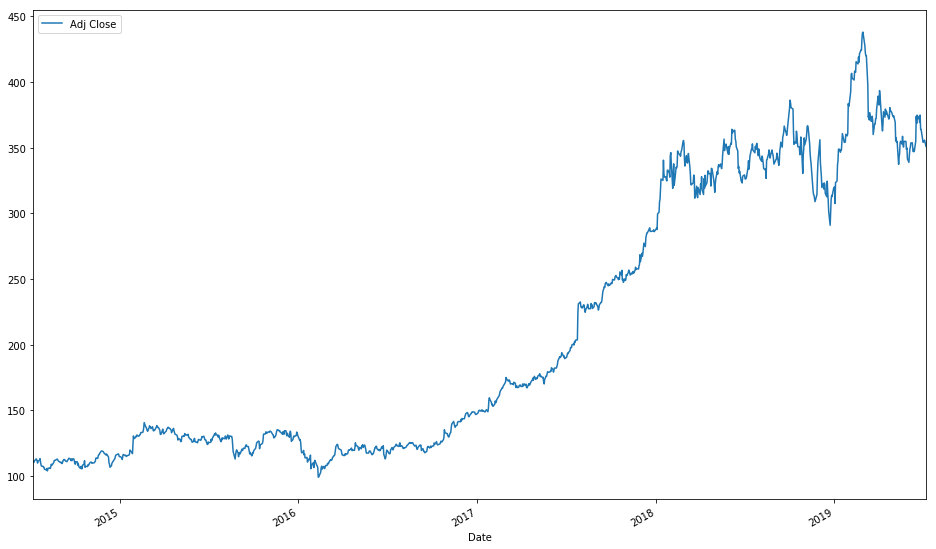

In [79]:
ba_sub = ba[(ba['Date'] >= '2014-07-08') & (ba['Date'] <= '2019-07-08')]
#ba_sub.plot(figsize=(20,10))
ba_sub.plot(x='Date', y='Adj Close',figsize=(16,10),legend = True)


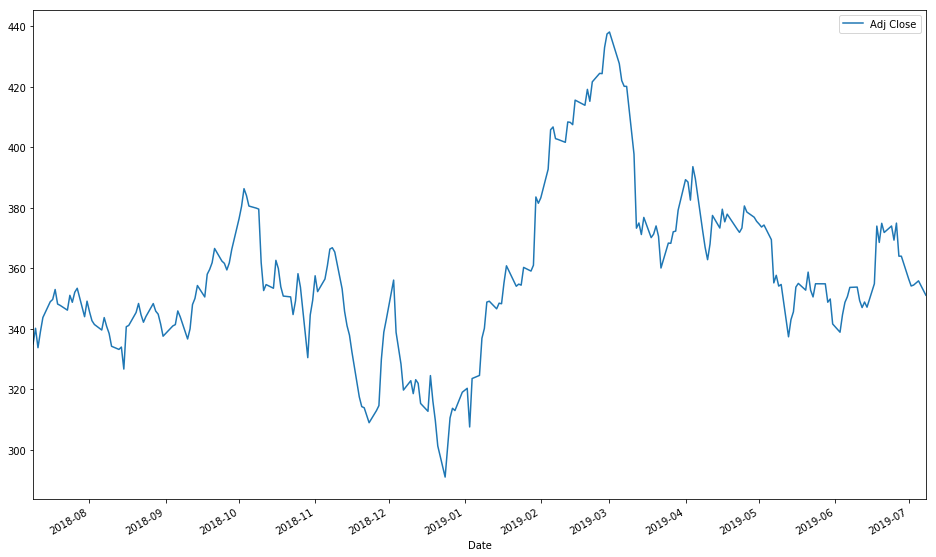

In [81]:
ba_sub_2018 = ba[(ba['Date'] >= '2018-07-08') & (ba['Date'] <= '2019-07-08')]
ba_sub_2018.plot(x='Date', y='Adj Close',figsize=(16,10),legend = True)


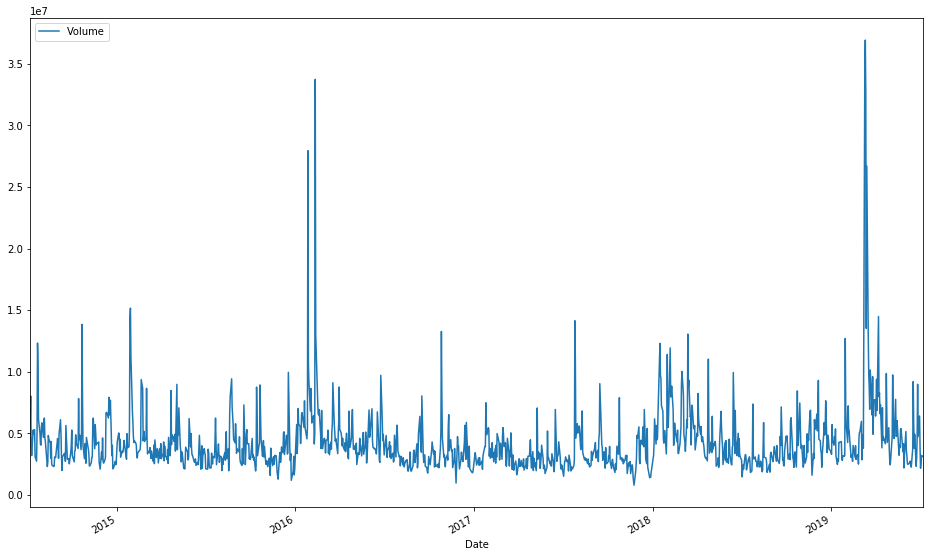

In [76]:
ba_sub.plot(x='Date', y='Volume',figsize=(16,10),legend = True)

In [41]:
stock = pd.read_csv('all_stocks_5yr.csv')
stock.head(10)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
5,2013-02-15,13.93,14.61,13.93,14.50,15628000,AAL
6,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL
7,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL
8,2013-02-21,13.62,13.95,12.90,13.37,11922100,AAL
9,2013-02-22,13.57,13.60,13.21,13.57,6071400,AAL


In [42]:
stock.tail(10)

,date,open,high,low,close,volume,Name
619030,2018-01-25,78.47,79.38,78.345,79.25,2327262,ZTS
619031,2018-01-26,79.49,80.13,79.380,80.09,2532808,ZTS
619032,2018-01-29,79.81,79.95,79.110,79.18,2662383,ZTS
619033,2018-01-30,78.44,78.69,77.910,78.35,3808707,ZTS
619034,2018-01-31,78.49,78.77,76.540,76.73,4136360,ZTS
619035,2018-02-01,76.84,78.27,76.690,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.730,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.180,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.130,73.27,4924323,ZTS
619039,2018-02-07,72.70,75.00,72.690,73.86,4534912,ZTS


In [43]:
stock.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [44]:
stock = stock.dropna(how='any',axis=0)

In [45]:
stock.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [46]:
stock.dtypes

date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
Name       object
dtype: object

In [47]:
stock['date'] = pd.to_datetime(stock['date'])

In [48]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
date      619029 non-null datetime64[ns]
open      619029 non-null float64
high      619029 non-null float64
low       619029 non-null float64
close     619029 non-null float64
volume    619029 non-null int64
Name      619029 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


In [55]:
stock.close.describe(percentiles=[0.01, 0.99])

count    619029.000000
mean         83.043305
std          97.388913
min           1.590000
1%           12.000000
50%          62.620000
99%         471.760000
max        2049.000000
Name: close, dtype: float64

In [57]:
stock.open.describe(percentiles=[0.01, 0.99])

count    619029.000000
mean         83.023334
std          97.378769
min           1.620000
1%           11.990000
50%          62.590000
99%         471.641600
max        2044.000000
Name: open, dtype: float64

In [109]:
import plotly.graph_objects as go
import chart_studio.plotly as py
import matplotlib.pyplot as plt
%matplotlib.

UsageError: Line magic function `%matplotlib.inline` not found.


In [81]:
AAPL = stock.loc[stock['Name'] == 'AAPL']
AAPL.head()
#df.loc[df['column_name'] == some_value]

,date,open,high,low,close,volume,Name
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [75]:
from matplotlib.pyplot import figure

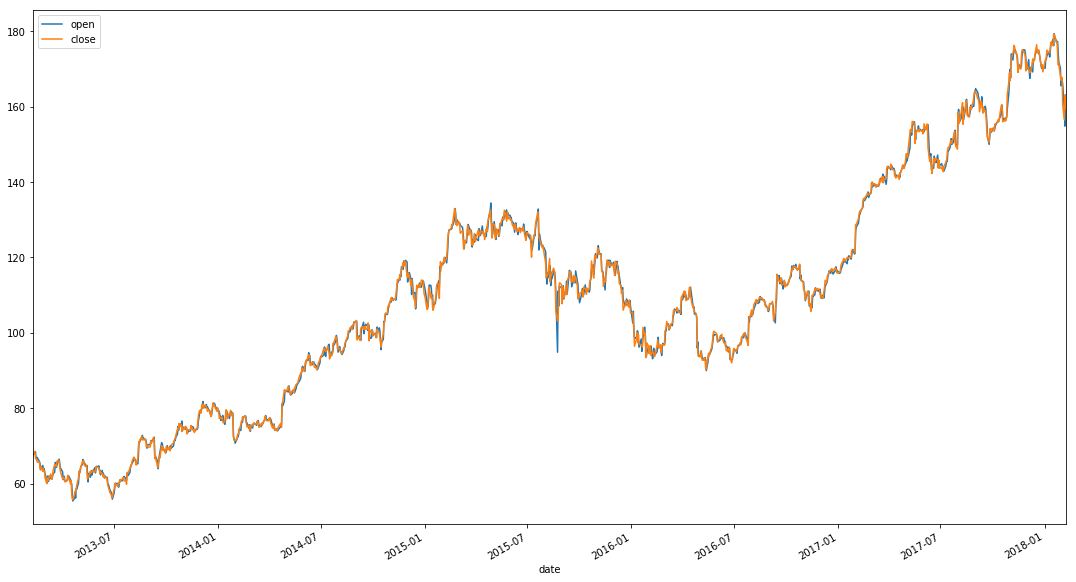

In [82]:
AAPL.plot(x = 'date', y = ['open','close'],figsize=(18.5,10.5))
plt.show()

In [163]:
stock.groupby('Name')['close'].mean().reset_index().sort_values(by='close', ascending=False).head()

,Name,close
360,PCLN,1312.873538
206,GOOG,725.403353
207,GOOGL,682.233847
58,AZO,619.703654
38,AMZN,576.880041


In [145]:
top_five = stock[stock['Name'].isin(['PCLN','GOOG','GOOGL','AZO','AMZN'])]
top_five.head()
#df2[df2['id'].isin(['SP.POP.TOTL','NY.GNP.PCAP.CD'])]

,date,open,high,low,close,volume,Name
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN


Name
AMZN     AxesSubplot(0.125,0.2;0.775x0.68)
AZO      AxesSubplot(0.125,0.2;0.775x0.68)
GOOG     AxesSubplot(0.125,0.2;0.775x0.68)
GOOGL    AxesSubplot(0.125,0.2;0.775x0.68)
PCLN     AxesSubplot(0.125,0.2;0.775x0.68)
Name: close, dtype: object

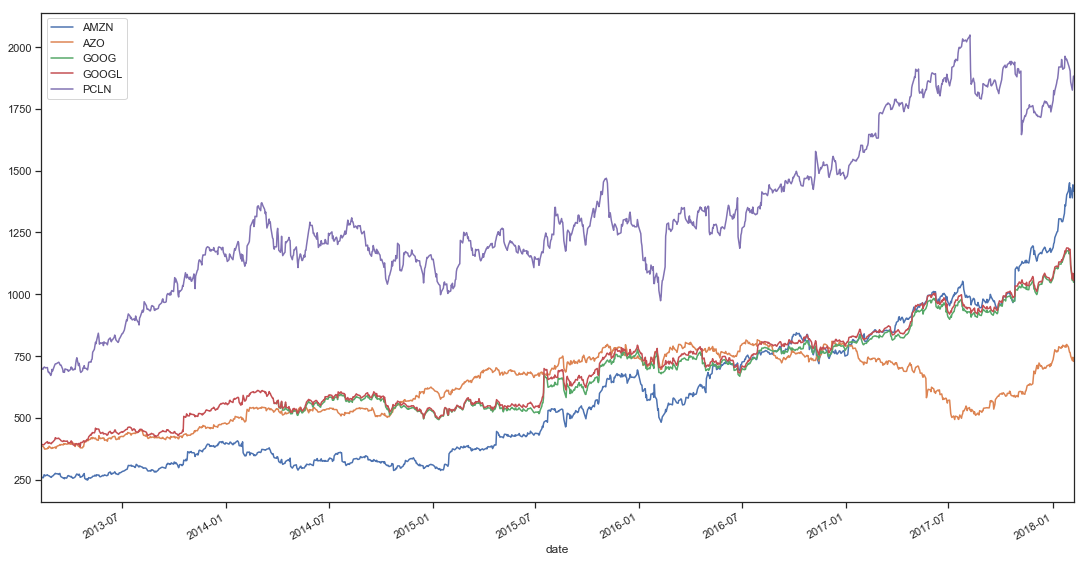

In [146]:
top_five.set_index('date', inplace=True)
plt.figure(figsize=[18.5,10.0])
top_five.groupby('Name')['close'].plot(legend=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Name
AMZN     AxesSubplot(0.125,0.2;0.775x0.68)
AZO      AxesSubplot(0.125,0.2;0.775x0.68)
GOOG     AxesSubplot(0.125,0.2;0.775x0.68)
GOOGL    AxesSubplot(0.125,0.2;0.775x0.68)
PCLN     AxesSubplot(0.125,0.2;0.775x0.68)
Name: high-low, dtype: object

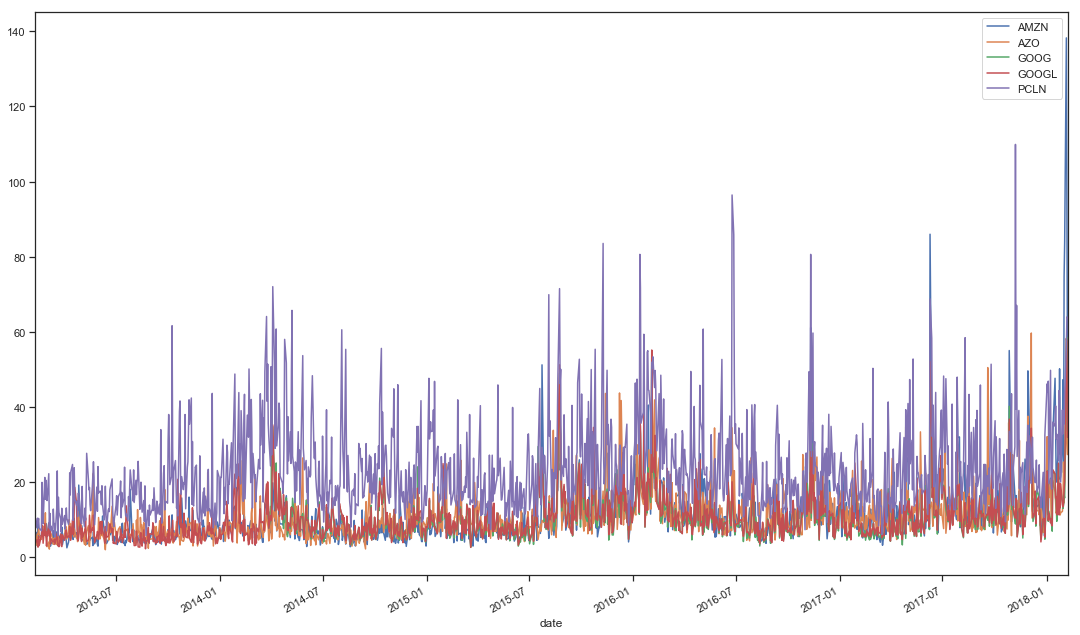

In [147]:
top_five['high-low'] = top_five['high'] - top_five['low']
plt.figure(figsize=[18.5,11.5])
top_five.groupby('Name')['high-low'].plot(legend=True)

In [148]:
top_five['daily_return'] = top_five['close'].pct_change()
top_five = top_five.dropna(how='any',axis=0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [149]:
top_five.head(10)

,open,high,low,close,volume,Name,high-low,daily_return
date,,,,,,,,
2013-02-11,263.20,263.250,256.600,257.21,3403403,AMZN,6.650,-0.018095
2013-02-12,259.19,260.160,257.000,258.70,2938660,AMZN,3.160,0.005793
2013-02-13,261.53,269.960,260.300,269.47,5292996,AMZN,9.660,0.041631
2013-02-14,267.37,270.650,265.400,269.24,3462780,AMZN,5.250,-0.000854
2013-02-15,267.63,268.920,263.110,265.09,3979832,AMZN,5.810,-0.015414
2013-02-19,265.91,270.110,264.500,269.75,2853752,AMZN,5.610,0.017579
2013-02-20,270.20,274.300,266.371,266.41,3528862,AMZN,7.929,-0.012382
2013-02-21,265.12,269.480,263.250,265.94,3637396,AMZN,6.230,-0.001764
2013-02-22,266.62,267.110,261.610,265.42,3123402,AMZN,5.500,-0.001955


Name
AMZN     AxesSubplot(0.125,0.2;0.775x0.68)
AZO      AxesSubplot(0.125,0.2;0.775x0.68)
GOOG     AxesSubplot(0.125,0.2;0.775x0.68)
GOOGL    AxesSubplot(0.125,0.2;0.775x0.68)
PCLN     AxesSubplot(0.125,0.2;0.775x0.68)
Name: daily_return, dtype: object

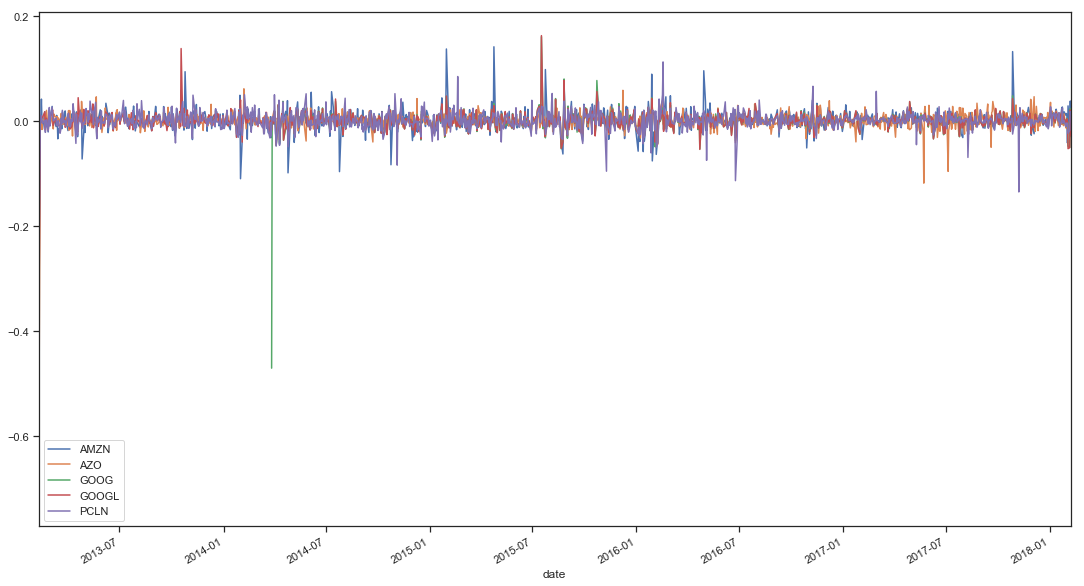

In [150]:
plt.figure(figsize=[18.5,10.5])
top_five.groupby('Name')['daily_return'].plot(legend=True)

In [151]:
import seaborn as sns
from datetime import datetime

Name
AMZN     AxesSubplot(0.125,0.125;0.775x0.755)
AZO      AxesSubplot(0.125,0.125;0.775x0.755)
GOOG     AxesSubplot(0.125,0.125;0.775x0.755)
GOOGL    AxesSubplot(0.125,0.125;0.775x0.755)
PCLN     AxesSubplot(0.125,0.125;0.775x0.755)
Name: daily_return, dtype: object

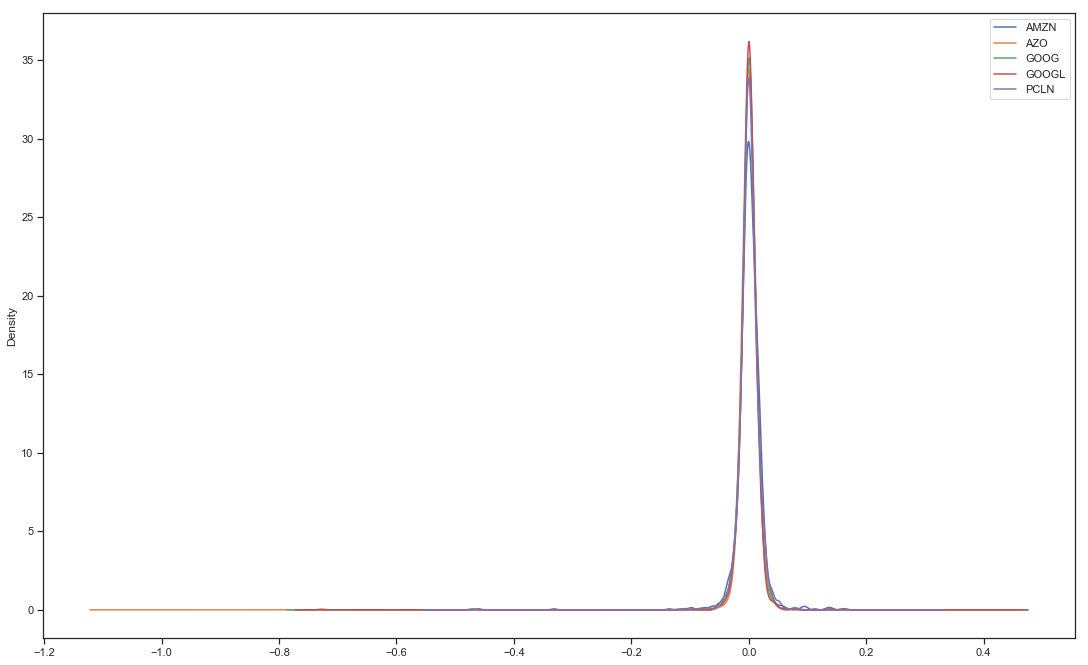

In [156]:
plt.figure(figsize=[18.5,11.5])
top_five.groupby('Name')['daily_return'].plot(kind = 'density',legend=True)

In [161]:
# Top 1000 most freq stocks
freqstocks=stock.Name.value_counts()[:1000].index.tolist()

#Dataframe of only those 
stocksmarketfreq=stock[stock.Name.isin(freqstocks)]

#calculating standatd deviation of those 
stocksmarketfreq.groupby('Name')['close'].std().sort_values(ascending=True)[:5]

Name
AES     1.487180
PBCT    1.648513
NWS     1.791033
WU      1.821214
F       1.957269
Name: close, dtype: float64

In [169]:
news = pd.read_csv("tweets.csv", encoding = "ISO-8859-1")

In [170]:
news.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [171]:
news.tail()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [178]:
news.isnull().sum()

0                                                                                                                      0
1467810369                                                                                                             0
Mon Apr 06 22:19:45 PDT 2009                                                                                           0
NO_QUERY                                                                                                               0
_TheSpecialOne_                                                                                                        0
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D    0
dtype: int64

In [173]:
price = pd.read_csv("historical_stock_prices.csv")

In [174]:
price['date'] = pd.to_datetime(price['date'])

In [183]:
price.sort_values(by='date')

,ticker,open,close,adj_close,low,high,volume,date
4285669,XOM,1.929688,1.937500,0.025623,1.925781,1.937500,1174400,1970-01-02
14184994,AA,7.140915,7.140915,1.986261,7.140915,7.225020,22500,1970-01-02
15384996,BA,0.925926,0.979424,0.229325,0.925926,0.979424,634400,1970-01-02
18215303,DIS,0.688281,0.683144,0.282199,0.683144,0.689565,1109700,1970-01-02
18189682,PG,1.710938,1.718750,0.020346,1.708984,1.722656,832000,1970-01-02
2515733,CNP,11.099500,11.169750,0.107916,10.994125,11.204875,24400,1970-01-02
12438062,CAT,3.541667,3.458333,0.378521,3.447917,3.541667,276000,1970-01-02
13574437,HON,4.082415,4.165306,0.283969,4.082415,4.227475,54200,1970-01-02
5920048,JNJ,1.250000,1.218750,0.000004,1.218750,1.253472,1195200,1970-01-02
10951931,IP,9.153107,9.430473,1.183667,9.122288,9.461292,71700,1970-01-02


In [179]:
price.isnull().sum()

ticker       0
open         0
close        0
adj_close    0
low          0
high         0
volume       0
date         0
dtype: int64

In [176]:
price.dtypes

ticker               object
open                float64
close               float64
adj_close           float64
low                 float64
high                float64
volume                int64
date         datetime64[ns]
dtype: object

In [198]:
AMZN = top_five[top_five['Name'].isin(['AMZN'])]

In [209]:
AMZN.index = pd.to_datetime(AMZN.index) 
AMZN.head()


,open,high,low,close,volume,Name,high-low,daily_return
date,,,,,,,,
2013-02-11,263.20,263.25,256.60,257.21,3403403,AMZN,6.65,-0.018095
2013-02-12,259.19,260.16,257.00,258.70,2938660,AMZN,3.16,0.005793
2013-02-13,261.53,269.96,260.30,269.47,5292996,AMZN,9.66,0.041631
2013-02-14,267.37,270.65,265.40,269.24,3462780,AMZN,5.25,-0.000854
2013-02-15,267.63,268.92,263.11,265.09,3979832,AMZN,5.81,-0.015414


In [210]:
AMZN.tail()

,open,high,low,close,volume,Name,high-low,daily_return
date,,,,,,,,
2018-02-01,1445.00,1459.88,1385.14,1390.00,9113808,AMZN,74.74,-0.041967
2018-02-02,1477.39,1498.00,1414.00,1429.95,11125722,AMZN,84.00,0.028741
2018-02-05,1402.62,1458.98,1320.72,1390.00,11494985,AMZN,138.26,-0.027938
2018-02-06,1361.46,1443.99,1351.79,1442.84,11066819,AMZN,92.20,0.038014
2018-02-07,1449.00,1460.99,1415.15,1416.78,7162741,AMZN,45.84,-0.018062


In [214]:
AMZN_wk = AMZN['close'].resample('W-MON').mean()
AMZN_train = AMZN_wk['2013-02-11':'2017-02-11']
AMZN_train.tail()

date
2017-01-09    776.842
2017-01-16    806.425
2017-01-23    810.490
2017-01-30    832.852
2017-02-06    822.724
Freq: W-MON, Name: close, dtype: float64

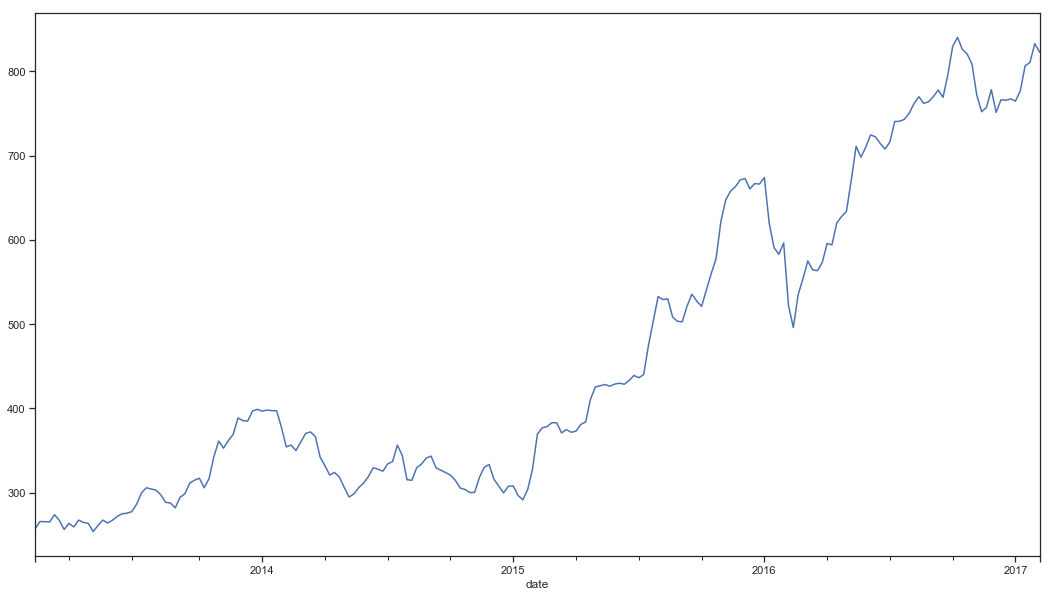

In [215]:
AMZN_train.plot(figsize = (18,10))

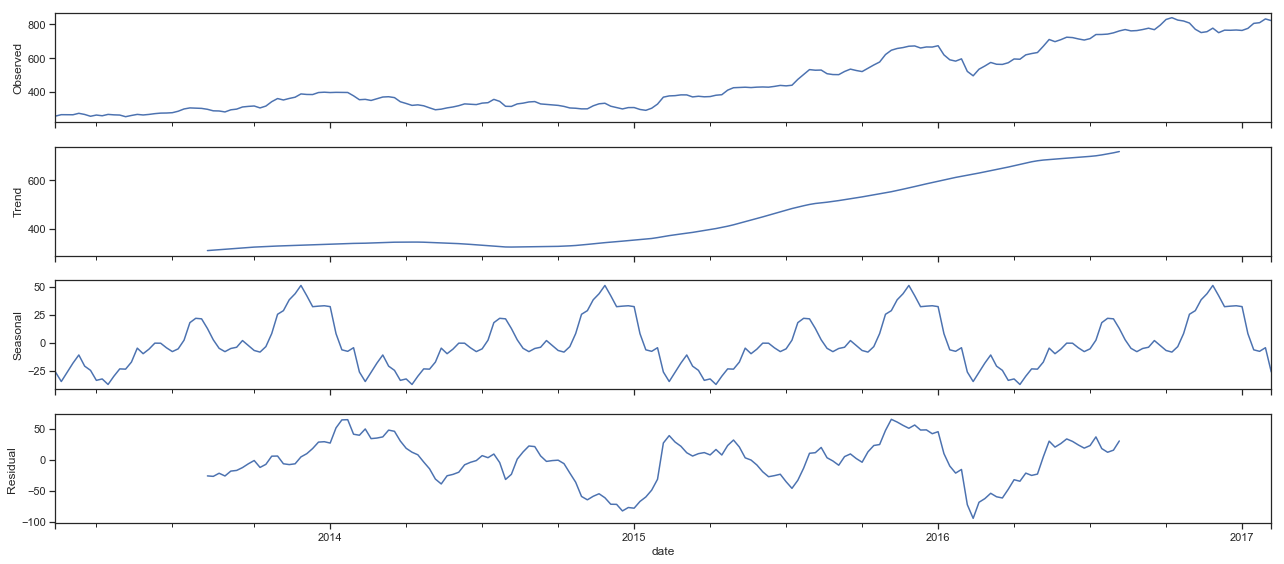

In [218]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(AMZN_train, model='additive')
fig = decomposition.plot()
plt.show()

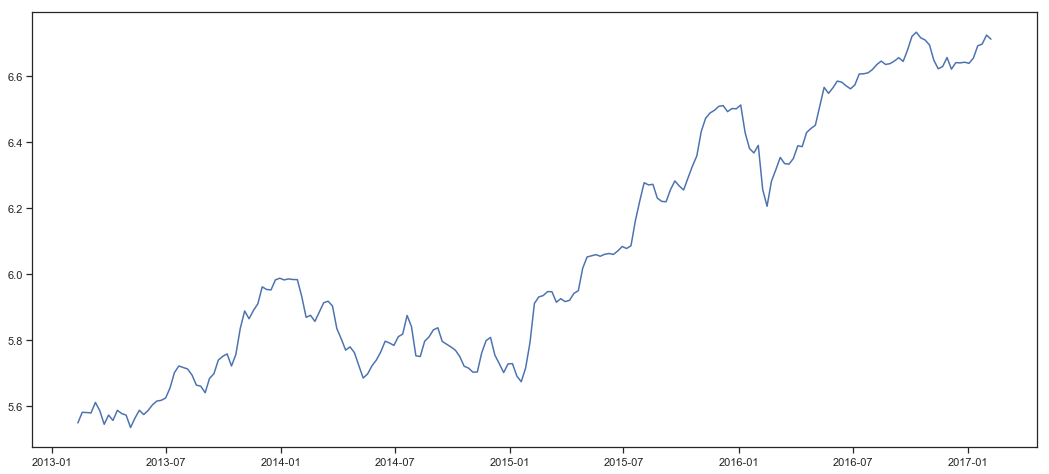

In [223]:
AMZN_train_log = np.log(AMZN_train)
plt.plot(AMZN_train_log)

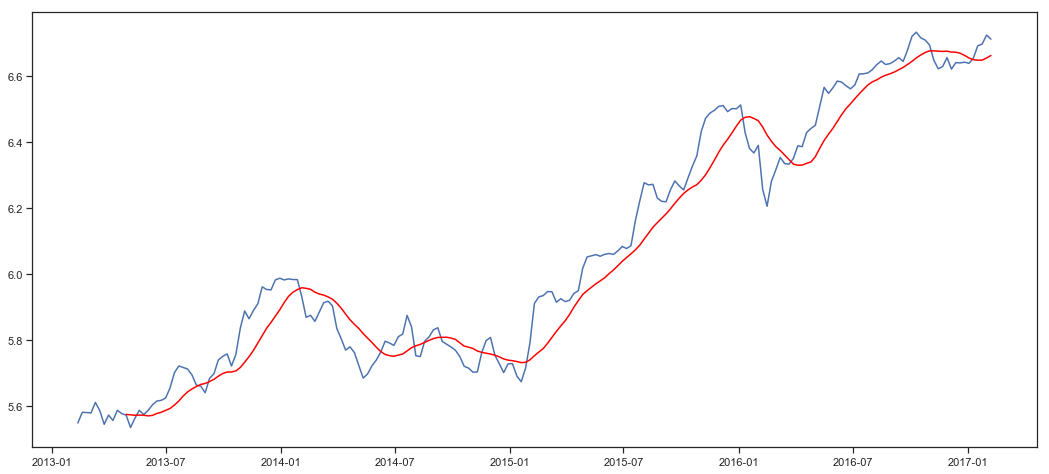

In [225]:
moving_avg = AMZN_train_log.rolling(12).mean()
plt.plot(AMZN_train_log)
plt.plot(moving_avg, color='red')

In [277]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import datetime

In [278]:
data = pd.read_csv("AEP_hourly.csv")

In [279]:
data.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [280]:
data.dtypes

Datetime     object
AEP_MW      float64
dtype: object

In [293]:
data["Date"] = pd.to_datetime(data["Datetime"]).dt.date
data["Time"] = pd.to_datetime(data["Datetime"]).dt.time

In [282]:
data.head()

,Datetime,AEP_MW,Date,Time
0,2004-12-31 01:00:00,13478.0,2004-12-31,01:00:00
1,2004-12-31 02:00:00,12865.0,2004-12-31,02:00:00
2,2004-12-31 03:00:00,12577.0,2004-12-31,03:00:00
3,2004-12-31 04:00:00,12517.0,2004-12-31,04:00:00
4,2004-12-31 05:00:00,12670.0,2004-12-31,05:00:00


In [283]:
data.tail()

,Datetime,AEP_MW,Date,Time
121268,2018-01-01 20:00:00,21089.0,2018-01-01,20:00:00
121269,2018-01-01 21:00:00,20999.0,2018-01-01,21:00:00
121270,2018-01-01 22:00:00,20820.0,2018-01-01,22:00:00
121271,2018-01-01 23:00:00,20415.0,2018-01-01,23:00:00
121272,2018-01-02 00:00:00,19993.0,2018-01-02,00:00:00


In [284]:
data.isnull().sum()

Datetime    0
AEP_MW      0
Date        0
Time        0
dtype: int64

In [285]:
df1 = data

In [286]:
df1[df1["AEP_MW"] == data["AEP_MW"].max()]

,Datetime,AEP_MW,Date,Time
30221,2008-10-20 14:00:00,25695.0,2008-10-20,14:00:00


In [287]:
df1[df1["AEP_MW"] == data["AEP_MW"].min()]

,Datetime,AEP_MW,Date,Time
100759,2016-10-02 05:00:00,9581.0,2016-10-02,05:00:00


In [295]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [296]:
data_date = data.groupby('Date')['AEP_MW'].sum().reset_index()

In [297]:
# Indexing with time series data
data_date = data_date.set_index('Date')
data_date.index

Index([2004-10-01, 2004-10-02, 2004-10-03, 2004-10-04, 2004-10-05, 2004-10-06,
       2004-10-07, 2004-10-08, 2004-10-09, 2004-10-10,
       ...
       2018-07-25, 2018-07-26, 2018-07-27, 2018-07-28, 2018-07-29, 2018-07-30,
       2018-07-31, 2018-08-01, 2018-08-02, 2018-08-03],
      dtype='object', name='Date', length=5055)

In [298]:
data_date.index = pd.to_datetime(data_date.index)

In [299]:
data_month = data_date['AEP_MW'].resample('MS').mean()
data_month.tail()

Date
2018-04-01    327341.866667
2018-05-01    338808.129032
2018-06-01    367326.000000
2018-07-01    382238.935484
2018-08-01    251647.000000
Freq: MS, Name: AEP_MW, dtype: float64

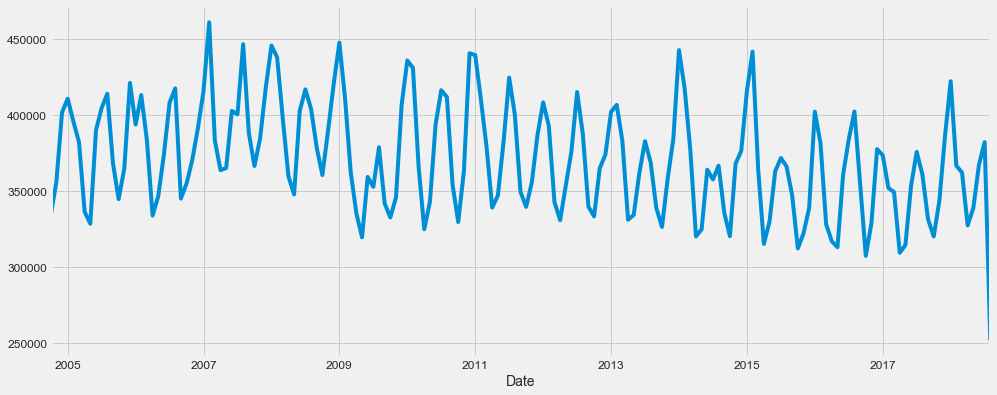

In [301]:
data_month.plot(figsize=(15, 6))
plt.show()

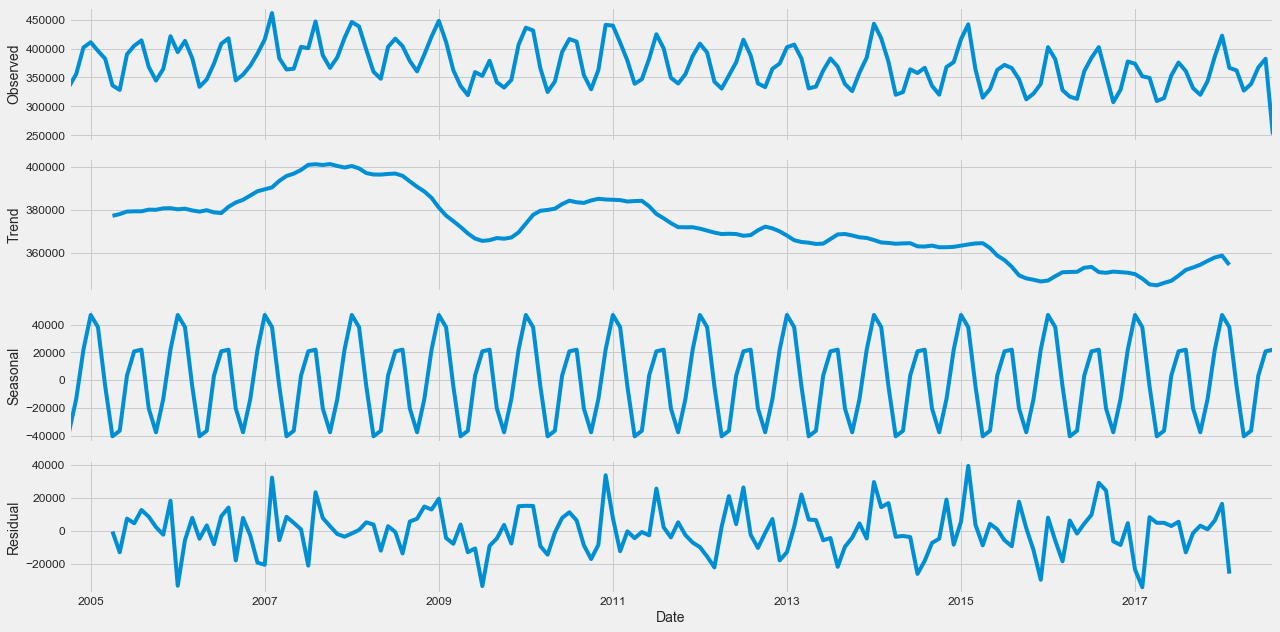

In [314]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 9
decomposition = sm.tsa.seasonal_decompose(data_month, model='additive')
fig = decomposition.plot()
plt.show()

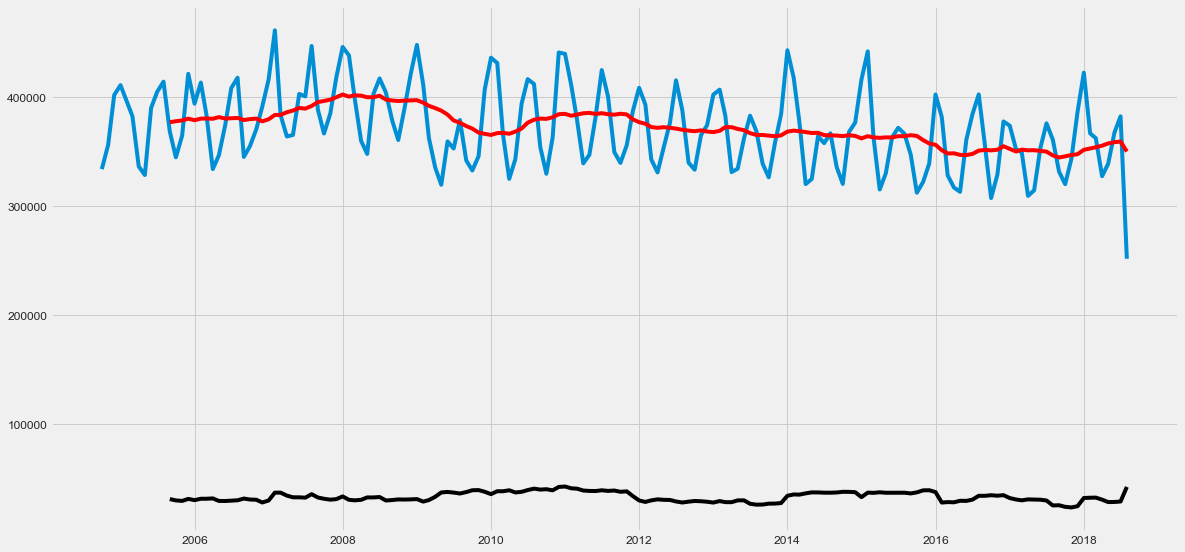

In [321]:
rolling_mean = data_month.rolling(12).mean()
rolling_std = data_month.rolling(12).std()
plt.plot(data_month)
plt.plot(rolling_mean, color='red')
plt.plot(rolling_std, color = 'black')

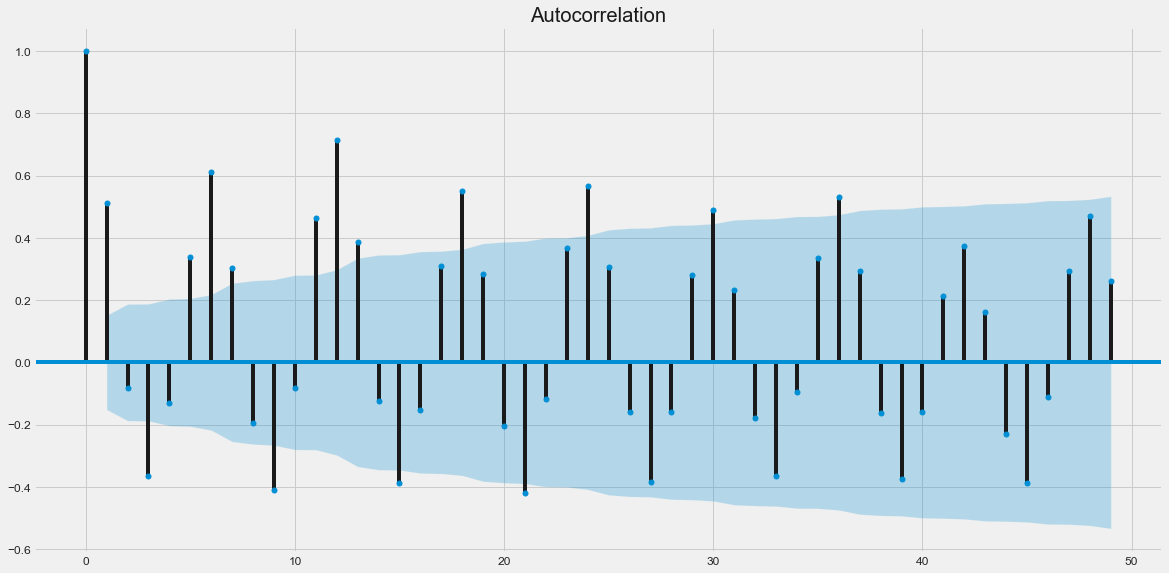

In [535]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_month, lags = range(0,50)).show()

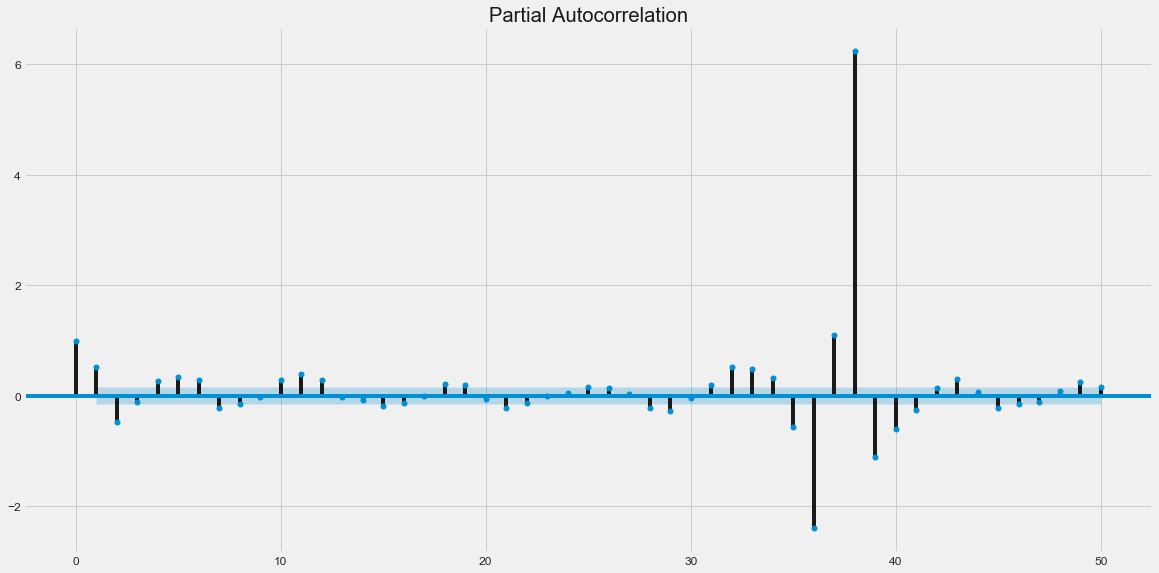

In [325]:
plot_pacf(data_month, lags=50)
plt.show()

In [329]:
ARIMA = sm.tsa.statespace.SARIMAX(data_month,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = ARIMA.fit()


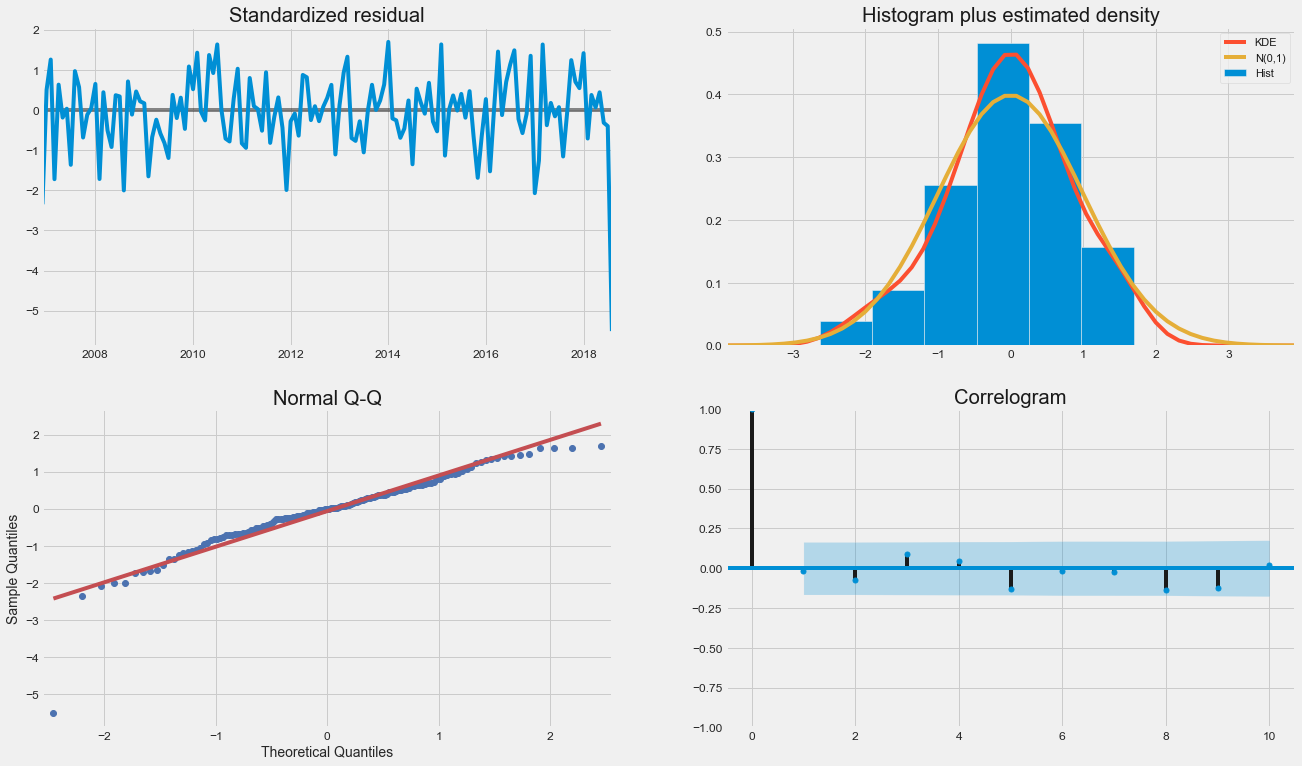

In [332]:
results.plot_diagnostics(figsize=(20, 12))
plt.show()

In [336]:
from statsmodels.tsa.stattools import adfuller as ADF
print(ADF(data_month))

(-0.5842575253497144, 0.8744996518706418, 12, 154, {'1%': -3.473542528196209, '5%': -2.880497674144038, '10%': -2.576878053634677}, 3441.9834237484615)


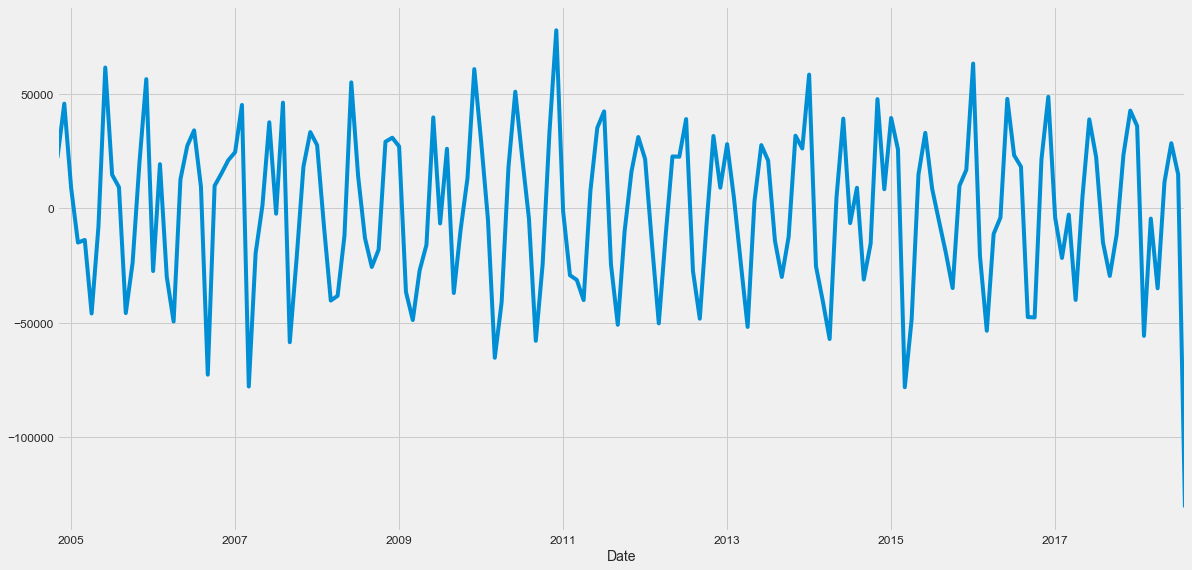

In [337]:
D_data = data_month.diff().dropna() 
D_data.columns = ['diff']  
D_data.plot()

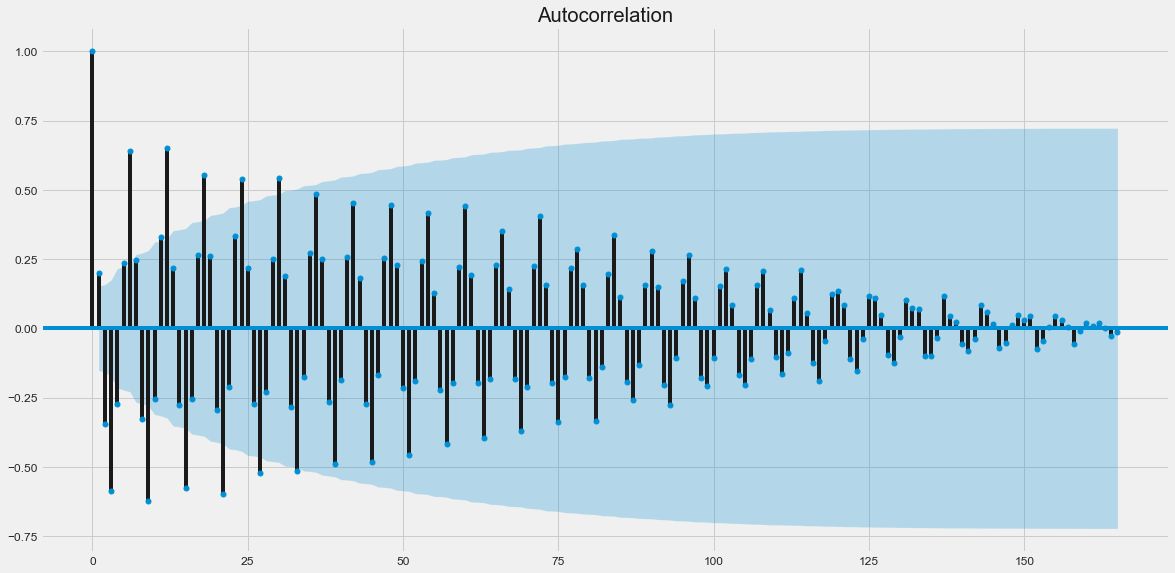

In [338]:
plot_acf(D_data).show()

In [339]:
print(ADF(D_data))

(-5.693851279820266, 7.957095930638674e-07, 11, 154, {'1%': -3.473542528196209, '5%': -2.880497674144038, '10%': -2.576878053634677}, 3416.0839269572116)


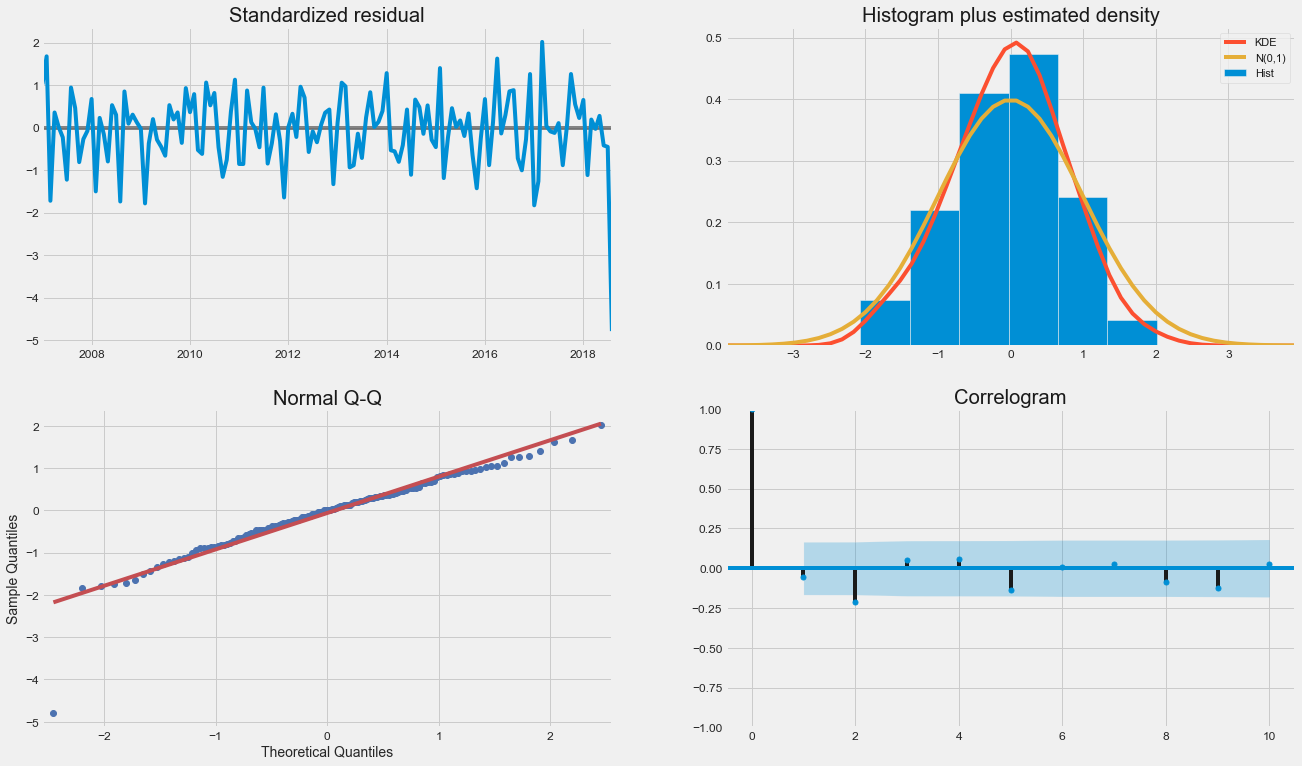

In [340]:
ARIMA = sm.tsa.statespace.SARIMAX(D_data,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = ARIMA.fit()

results.plot_diagnostics(figsize=(20, 12))
plt.show()

In [801]:
data_month

Date
2004-10-01    333841.064516
2004-11-01    355930.566667
2004-12-01    401705.290323
2005-01-01    410810.129032
2005-02-01    395919.464286
2005-03-01    382177.483871
2005-04-01    336310.400000
2005-05-01    328441.741935
2005-06-01    390008.000000
2005-07-01    404732.967742
2005-08-01    414026.161290
2005-09-01    368331.400000
2005-10-01    344689.258065
2005-11-01    364677.166667
2005-12-01    421166.129032
2006-01-01    393836.064516
2006-02-01    413184.678571
2006-03-01    383239.838710
2006-04-01    333868.466667
2006-05-01    346620.612903
2006-06-01    373994.833333
2006-07-01    408124.419355
2006-08-01    417604.709677
2006-09-01    345008.066667
2006-10-01    354913.258065
2006-11-01    370220.600000
2006-12-01    391295.935484
2007-01-01    415891.548387
2007-02-01    461109.678571
2007-03-01    383338.161290
                  ...      
2016-03-01    328059.709677
2016-04-01    316936.266667
2016-05-01    313016.419355
2016-06-01    360884.400000
2016-07-01    3

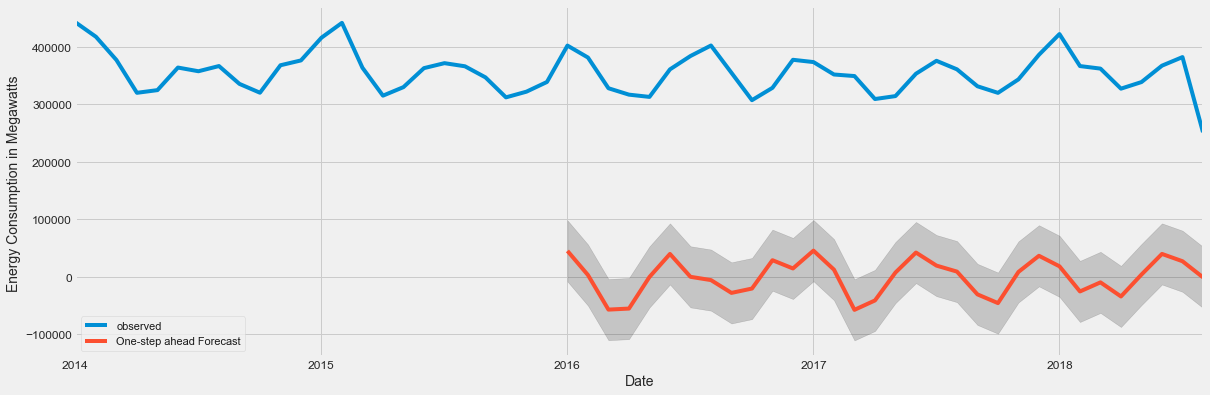

In [358]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = data_month['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', figsize=(18, 6))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_ylabel('Energy Consumption in Megawatts ')
plt.legend()
plt.show()

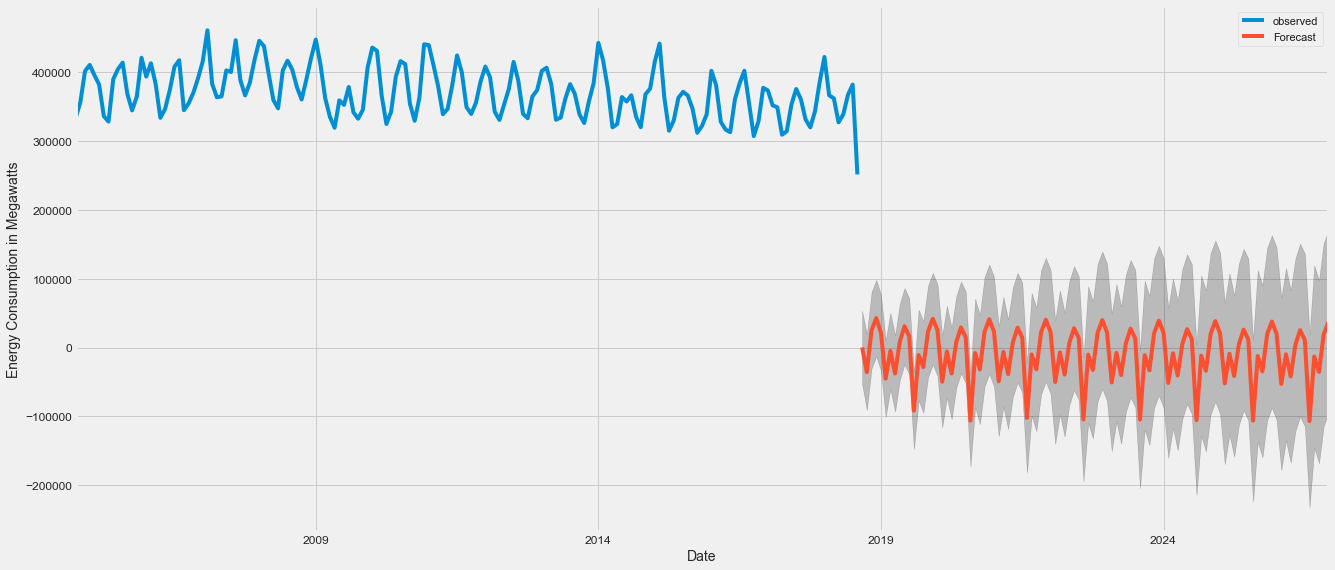

In [354]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = data_month.plot(label='observed', figsize=(20, 9))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_ylabel('Energy Consumption in Megawatts')
plt.legend()
plt.show()

In [842]:
from datetime import datetime
AEP = pd.read_csv("AEP_hourly.csv")
AEP.tail()

,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


In [843]:
AEP['Datetime'] = pd.to_datetime(AEP['Datetime'])
rng = (AEP['Datetime'] >= '2017-12-21') & (AEP['Datetime'] <= '2018-01-02')
AEP = AEP.loc[rng]
AEP.head()

,Datetime,AEP_MW
107378,2017-12-31 01:00:00,17422.0
107379,2017-12-31 02:00:00,17219.0
107380,2017-12-31 03:00:00,17313.0
107381,2017-12-31 04:00:00,17396.0
107382,2017-12-31 05:00:00,17512.0


In [844]:
AEP.dtypes

Datetime    datetime64[ns]
AEP_MW             float64
dtype: object

In [845]:
AEP.describe()

,AEP_MW
count,289.000000
mean,16728.778547
std,2223.379717
min,11832.000000
25%,14804.000000
50%,16997.000000
75%,18601.000000
max,21089.000000


In [846]:
AEP = AEP.groupby('Datetime')['AEP_MW'].sum().reset_index()


In [847]:
AEP = AEP.set_index('Datetime')

In [848]:
hourly = AEP['AEP_MW'].resample('H').mean()

In [849]:
hourly.head()

Datetime
2017-12-21 00:00:00    15186.0
2017-12-21 01:00:00    14729.0
2017-12-21 02:00:00    14463.0
2017-12-21 03:00:00    14456.0
2017-12-21 04:00:00    14520.0
Freq: H, Name: AEP_MW, dtype: float64

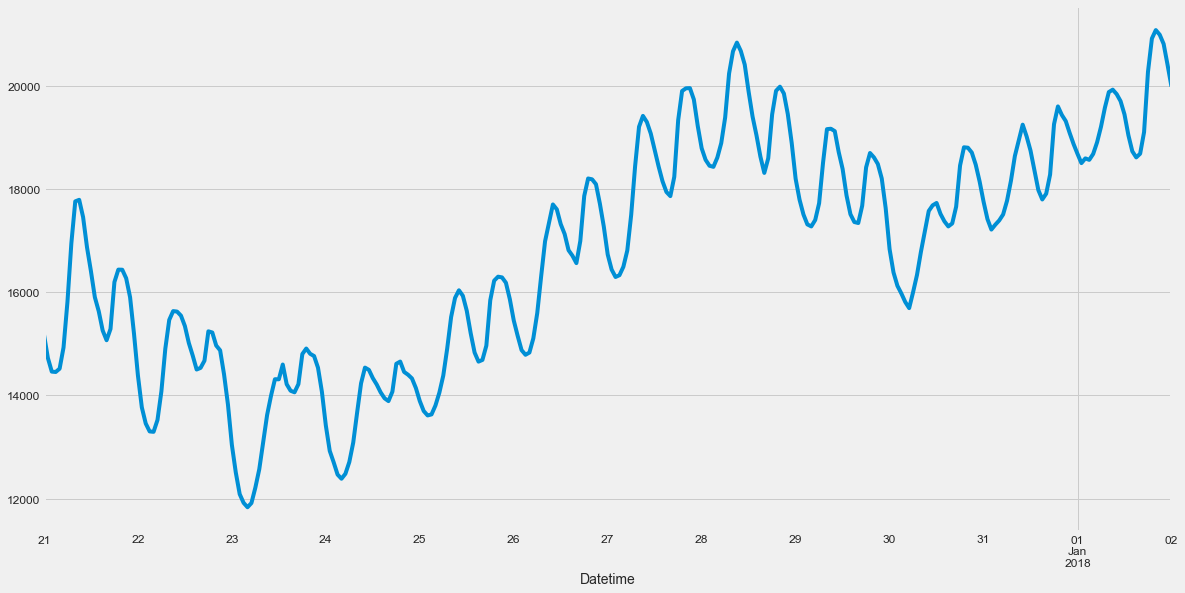

In [850]:
hourly.plot(figsize=(18, 9))
plt.show()

In [851]:
hourly.isnull().sum()

0

In [852]:
#hourly.dropna(inplace=True)
#hourly.reset_index(drop=True, inplace=True)

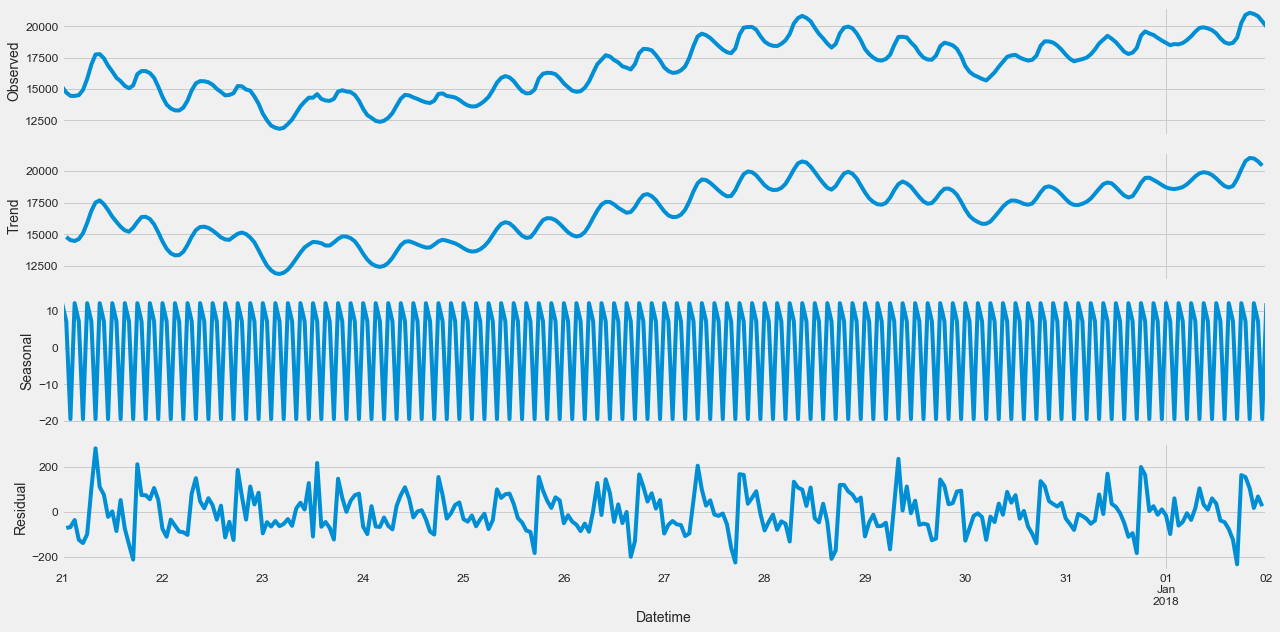

In [853]:
rcParams['figure.figsize'] = 18, 9
decomposition_hourly = sm.tsa.seasonal_decompose(hourly, model='additive',freq=3)
fig = decomposition_hourly.plot()
plt.show()

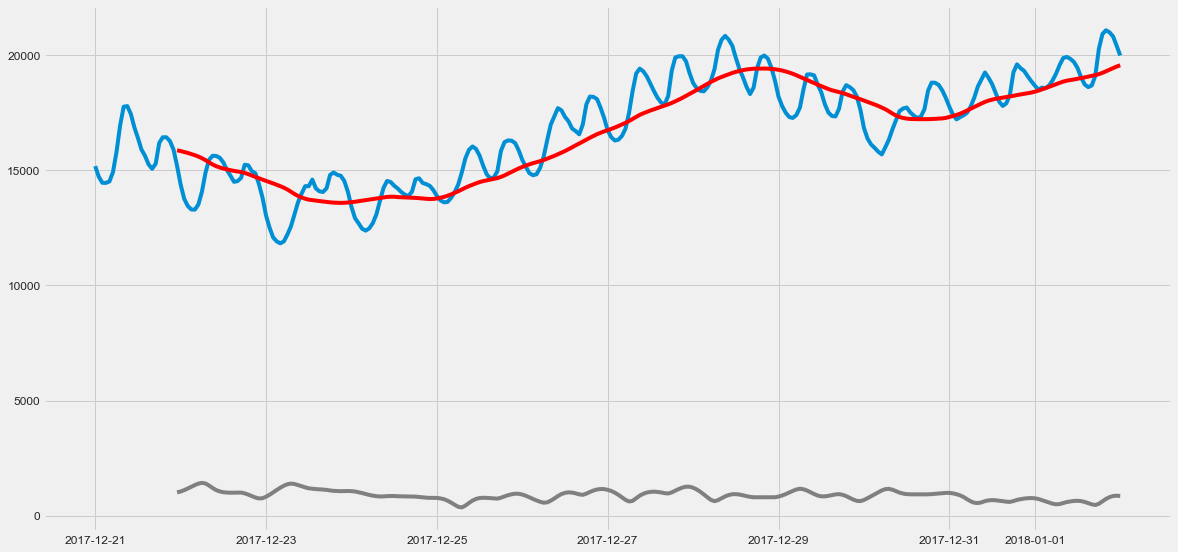

In [854]:
rolling_mean = hourly.rolling(24).mean()
rolling_std = hourly.rolling(24).std()
plt.plot(hourly)
plt.plot(rolling_mean, color='red')
plt.plot(rolling_std, color = 'grey')

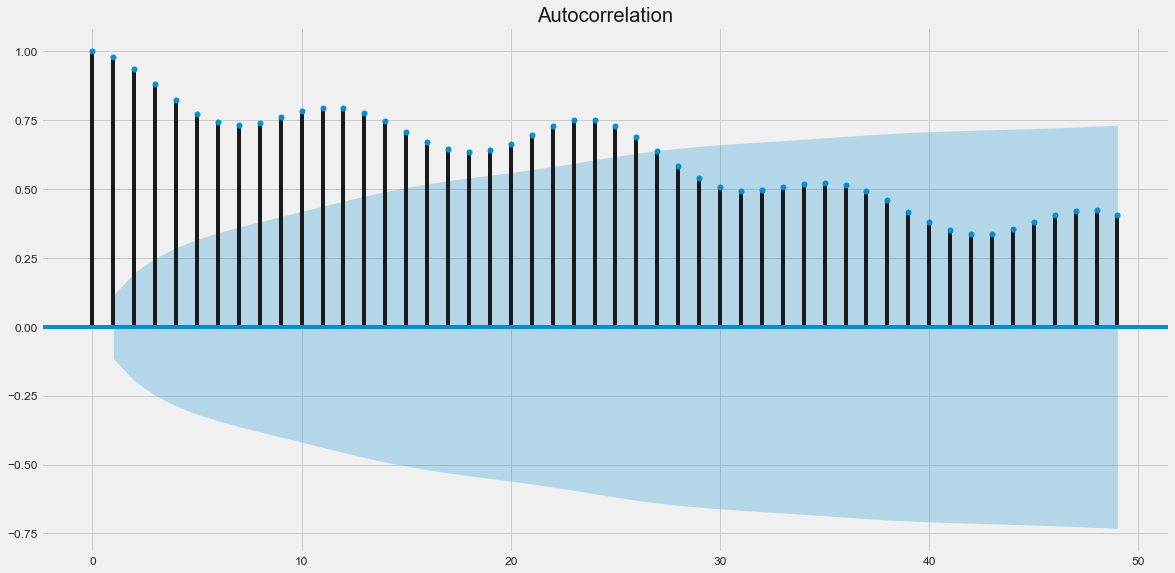

In [855]:
plot_acf(hourly, lags = range(0,50)).show()

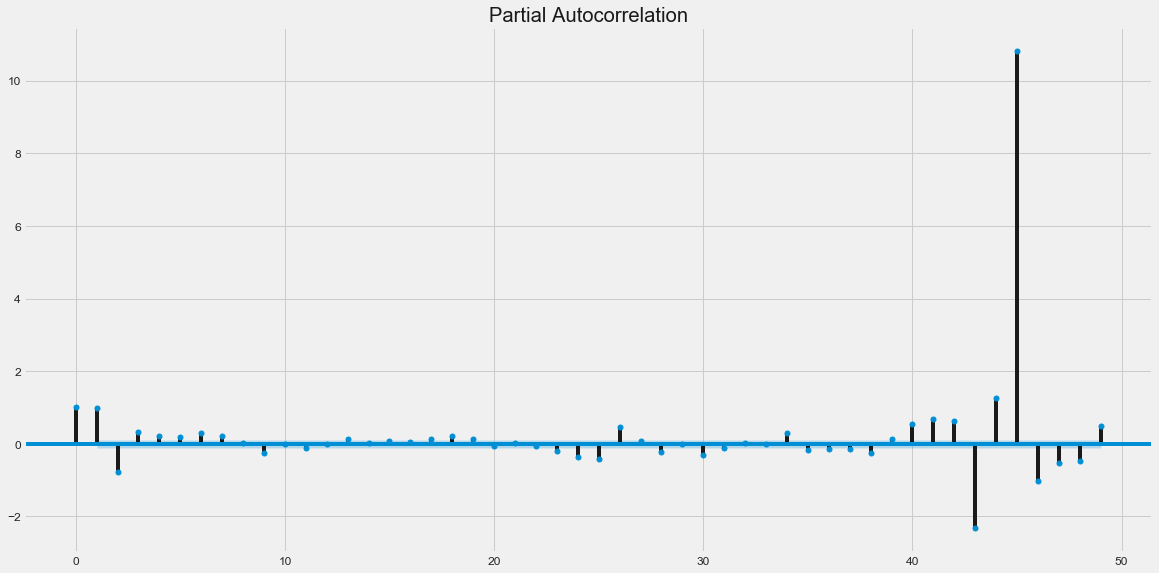

In [856]:
plot_pacf(hourly, lags = range(0,50)).show()

In [857]:
ARIMA = sm.tsa.statespace.SARIMAX(hourly,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = ARIMA.fit()

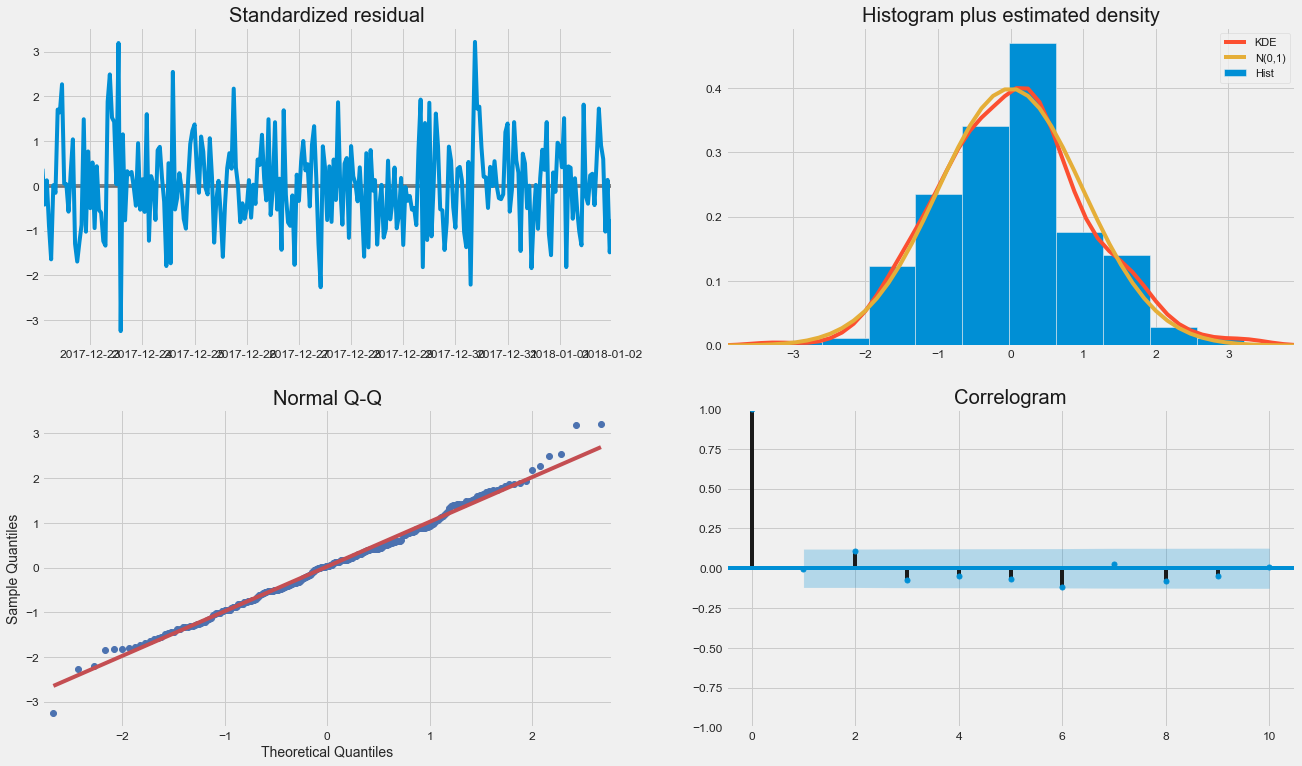

In [858]:
results.plot_diagnostics(figsize=(20, 12))
plt.show()

In [859]:
print(ADF(hourly))

(-0.33411719107763516, 0.9205313993296605, 16, 272, {'1%': -3.4546223782586534, '5%': -2.8722253212300277, '10%': -2.5724638500216264}, 3677.4897299633317)


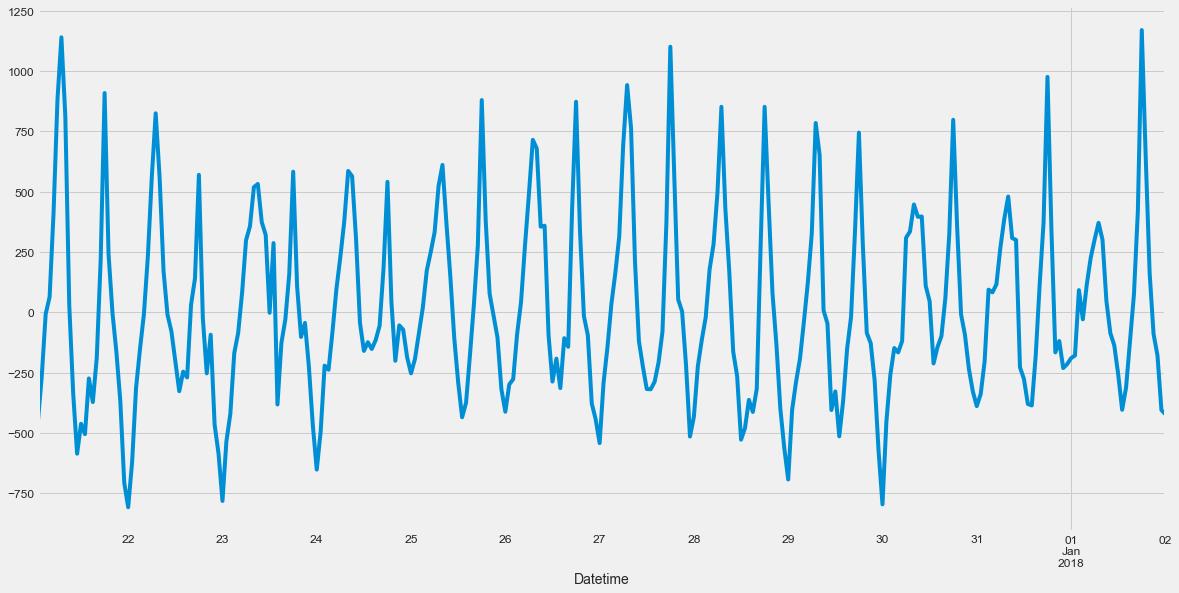

In [860]:
D_data = hourly.diff().dropna() 
D_data.columns = ['diff']  
D_data.plot()

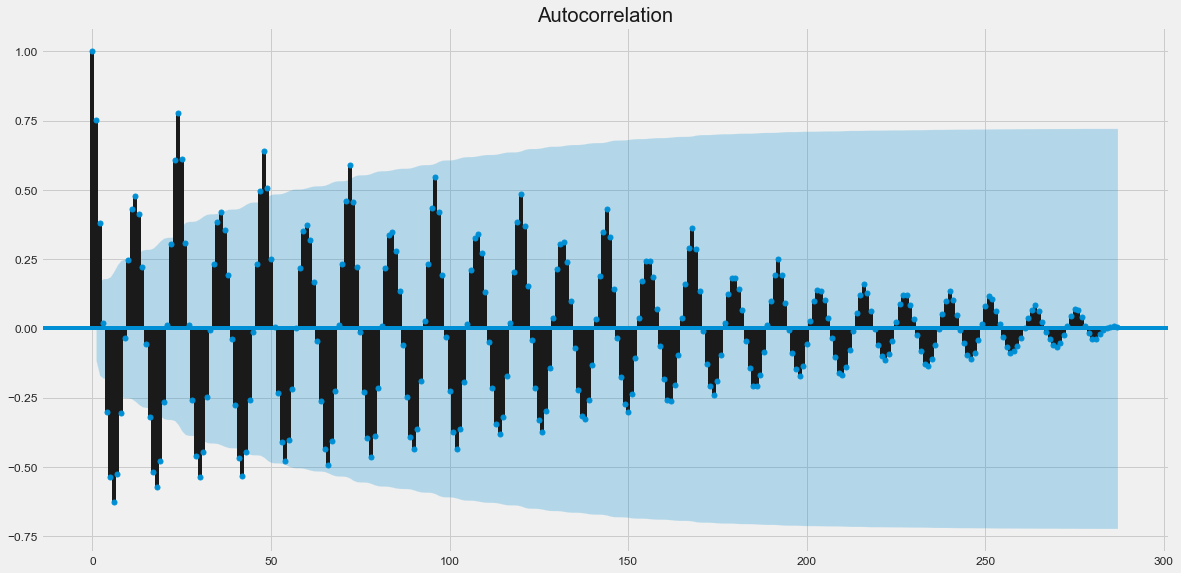

In [861]:
plot_acf(D_data).show()

In [862]:
ARIMA = sm.tsa.statespace.SARIMAX(D_data,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = ARIMA.fit()

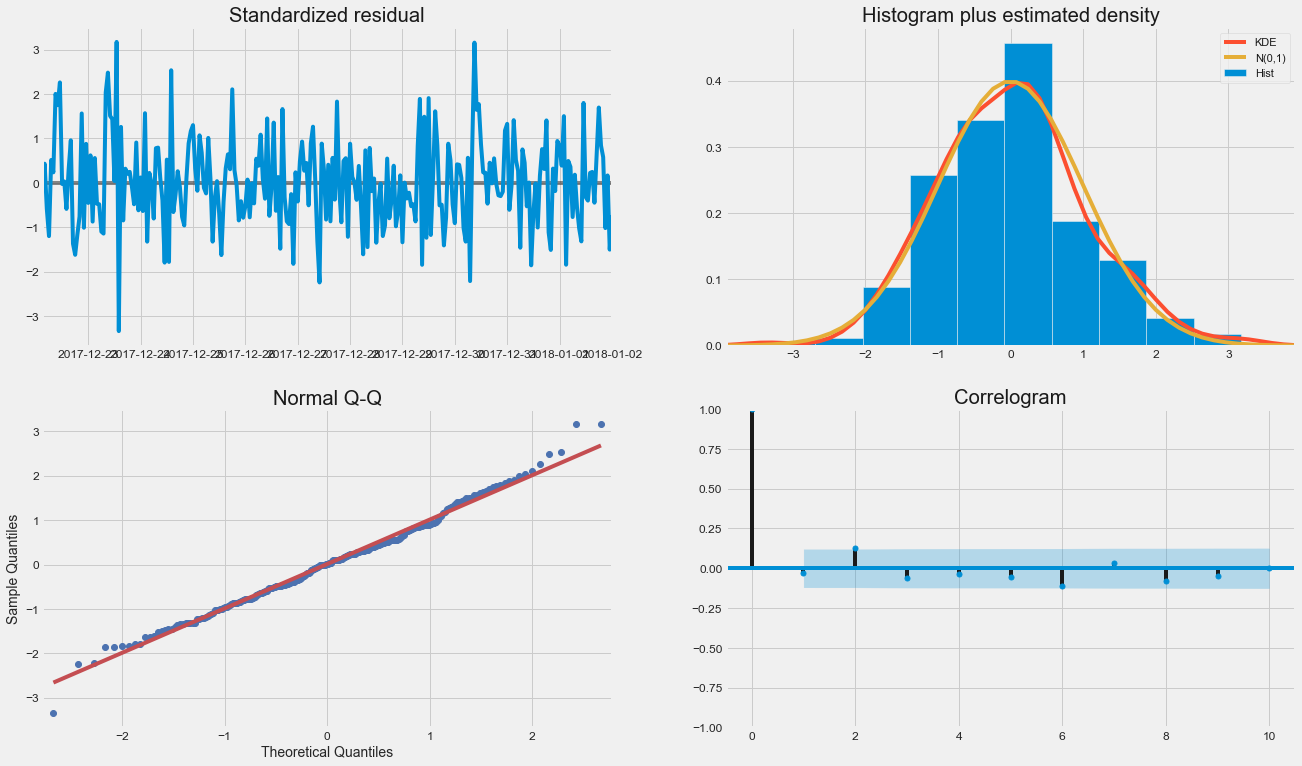

In [863]:
results.plot_diagnostics(figsize=(20, 12))
plt.show()

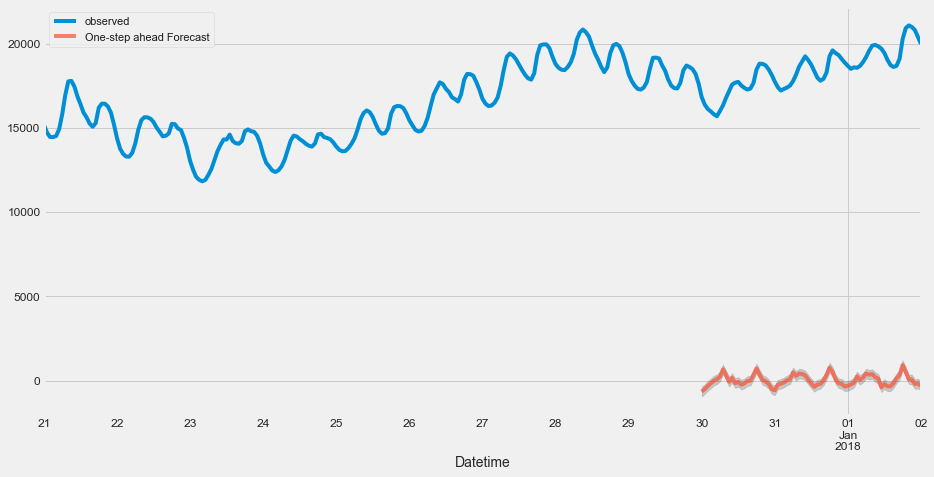

In [864]:
pred = results.get_prediction(start=pd.to_datetime('2017-12-30 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = hourly['2017-12-21 00:00:00':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show()

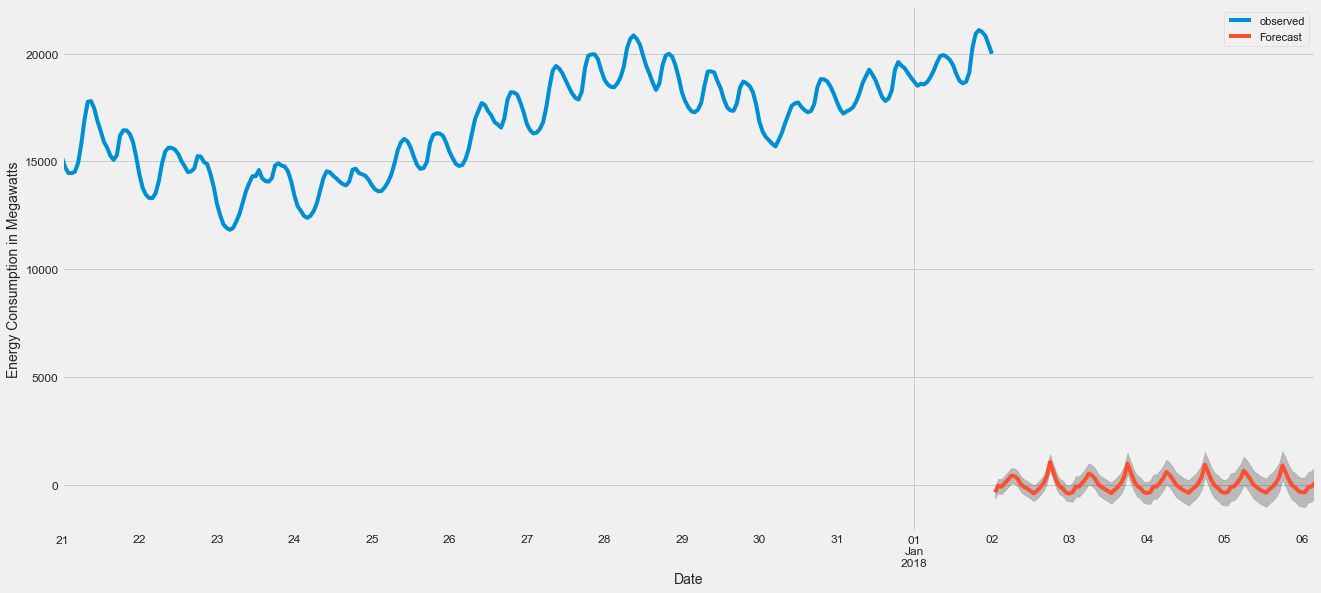

In [866]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = hourly.plot(label='observed', figsize=(20, 9))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption in Megawatts')
plt.legend()
plt.show()

In [867]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'